In [1]:
import os
from typing import Dict, List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torch.distributions import Categorical
import math
import torch.nn as nn
import random

In [2]:
env = gym.make("Pendulum-v1", render_mode="rgb_array")

device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)

obs_dim = env.observation_space.shape[0]
action_info = env.action_space
max_action = float(env.action_space.high[0])
print(env.observation_space.shape, obs_dim, action_info, max_action)

(3,) 3 Box(-2.0, 2.0, (1,), float32) 2.0


In [3]:
class ActionNetwork(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        """Initialization."""
        super(ActionNetwork, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_dim, 400), 
            nn.ReLU(),
            nn.Linear(400, 300), 
            nn.ReLU(), 
            nn.Linear(300, out_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        return max_action * torch.tanh(self.layers(x))
    
class QValueNetwork(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        '''状态价值，用来评估动作的好坏程度'''
        super(QValueNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_dim + out_dim, 400), 
            nn.ReLU(),
            nn.Linear(400, 300), 
            nn.ReLU(), 
            nn.Linear(300, 1)
        )
        
    def forward(self, x: torch.Tensor, a: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        exp_a = a.unsqueeze(1)
        t = torch.cat([x, exp_a], 1)
        return self.layers(t)

### 使用目标网络

In [8]:
actor = ActionNetwork(obs_dim, 1)
actor_target = ActionNetwork(obs_dim, 1)
actor_target.load_state_dict(actor.state_dict())
actor_optimizer = optim.Adam(actor.parameters(), lr=0.0001)

critic = QValueNetwork(obs_dim, 1)
critic_target = QValueNetwork(obs_dim, 1)
critic_target.load_state_dict(critic.state_dict())
critic_optimizer = optim.Adam(critic.parameters(), lr=0.0001)

In [9]:
def critic_value(state, action):
    return critic(torch.FloatTensor(state).to(device), torch.FloatTensor(action).to(device))

def critic_target_value(state, action):
    return critic_target(torch.FloatTensor(state).to(device), torch.FloatTensor(action).to(device))

def get_action(state):
    action = actor(torch.FloatTensor(state).to(device))
    return action.cpu().data.numpy().flatten()

def get_action_target(state):
    action = actor_target(torch.FloatTensor(state).to(device))
    return action.cpu().data.numpy().flatten()

In [10]:
gamma = 0.98
tau = 0.005
exploration_noise = 0.1

steps = []
scores = []
view_losses = []
max_epoch = 1000
batch_size = 16

for i in range(max_epoch):
    score = 0
    step = 0
    cnt = 1
    
    s, _ = env.reset(seed=3)
    trajectories = []
    while True:
        '''让策略网络做预测'''
        action = get_action_target(s)
        action = (action + np.random.normal(0, exploration_noise, size=env.action_space.shape[0])).clip(
                    env.action_space.low, env.action_space.high)
        next_state, reward, terminated, truncated, _ = env.step(np.float32(action))
        done = terminated or truncated
        
        step += 1
        score += reward
#         print(np.float32(action), reward)
        
        trajectories.append([s, action[0], reward, next_state, float(done)])
        if done:
            steps.append(step)
            scores.append(score)
            break
        
        s = next_state
    # 结束一轮游戏
    avg_loss = 0
    L = len(trajectories)
#     print(score, L)
    for j in range(1 * L):
        states = []
        rewards = []
        actions = []
        next_states = []
        masks = []
        random.seed(j)
        for i in range(batch_size):
            random_numbers = random.sample(range(0, L), 1)
            state, reward, action, next_state, done = trajectories[random_numbers[0]]
            states.append(state)
            rewards.append(reward)
            actions.append(action)
            next_states.append(next_state)
#             print(random_numbers, state, reward, action)
            masks.append(1 - done)
            
        masks = torch.FloatTensor(masks).view(batch_size,-1).to(device)
#         print(masks.shape)
        '''让价值网络做预测'''
        q_t = critic_value(states, actions)
        next_actions = get_action_target(next_states)
        next_q_t = critic_target_value(next_states, next_actions)
        '''计算价值网络的 TD 目标和 TD 误差'''
        reward_t = torch.FloatTensor(rewards).view(batch_size,-1).to(device)
        y_t = reward_t + gamma * next_q_t * masks
#         print('reward_t:', reward_t.shape, 'y_t:', y_t.shape, 'rewards:', rewards, 'result:', (next_q_t * masks).shape)
        critic_loss = F.mse_loss(q_t, y_t)
        '''更新价值网络'''
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

        new_acts = get_action(states)
#         print(new_acts)
        actor_loss = -critic_value(states, new_acts).mean()
#         print(actor_loss)
#         print('state:', states)
#         print('act:', new_acts)
#         actor_loss = actor_loss.mean()
        avg_loss += actor_loss.item()

        '''更新策略网络'''
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

        for param, target_param in zip(critic.parameters(), critic_target.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        for param, target_param in zip(actor.parameters(), actor_target.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)


        cnt += 1
    
    view_losses.append(avg_loss / cnt)
         

/var/folders/j8/_j76m6hs2190rhbxfq166yt40000gn/T/ipykernel_46568/2652335244.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  return critic(torch.FloatTensor(state).to(device), torch.FloatTensor(action).to(device))


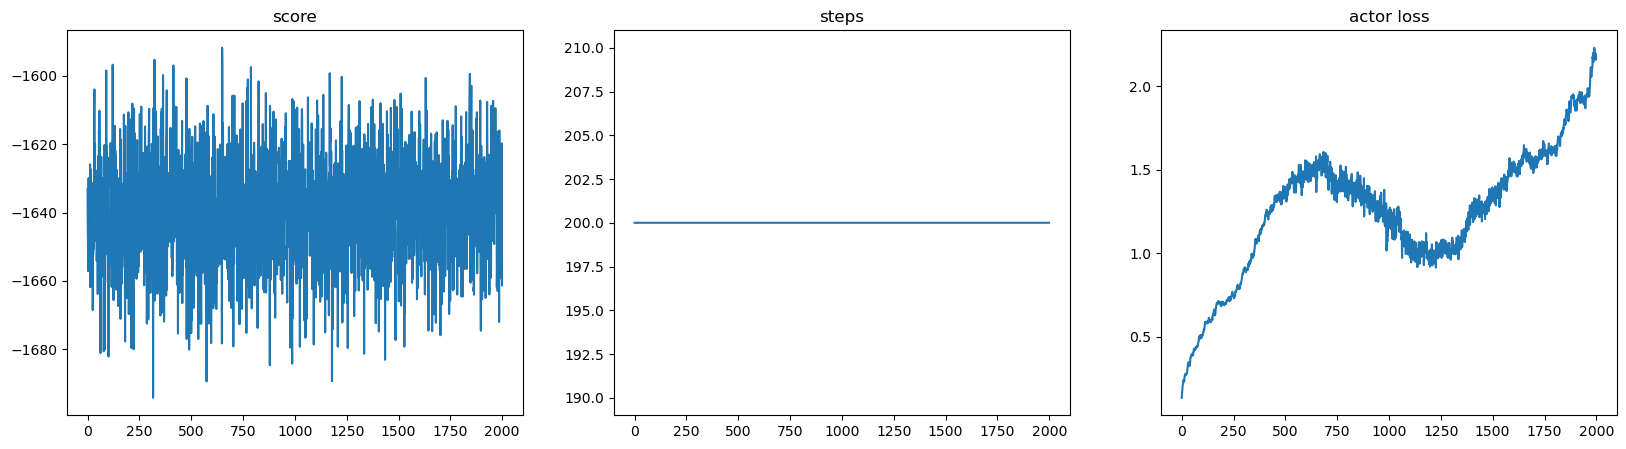

In [235]:
# 观察曲线
plt.figure(figsize=(20, 5))
plt.subplot(131)
# plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
plt.title('score')
plt.plot(scores)
plt.subplot(132)
plt.title('steps')
plt.plot(steps)
plt.subplot(133)
plt.title('actor loss')
plt.plot(view_losses)
plt.show()

In [7]:
# 观察效果
def test():
    dvideo_env = gym.wrappers.RecordVideo(env, video_folder='.')
    state, _ = dvideo_env.reset(seed=3)
    done = False
    score = 0
    step = 0
    while not done:
        action = get_action_target(state)
        print(action)
        next_state, reward, done, truncated, _ = dvideo_env.step(action)

        state = next_state
        score += reward
        step +=1
        
        if step > 200:
            break

    print("score: ", score, "step:", step)
    dvideo_env.close()
    
test()

/opt/homebrew/anaconda3/lib/python3.11/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/webberg/workspace/code/reinforce_learning/policy folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


[-0.06374994]
[-0.09291011]
[-0.08095942]
[-0.04896275]
[-0.0297825]
[-0.0195339]
[-0.00644147]
[0.00412945]
[0.01301689]
[0.01705071]
[0.02893683]
[0.05900522]
[0.08064301]
[0.08980168]
[0.06084774]
[0.07451075]
[0.09172127]
[0.11593996]
[0.1430966]
[0.18927084]
[0.21465714]
[0.24645406]
[0.27215222]
[0.28309014]
[0.28465834]
[0.28114042]
[0.28026977]
[0.2759537]
[0.26178148]
[0.23419312]
[0.1826196]
[0.08949497]
[-0.01272617]
[-0.07830157]
[-0.10018001]
[-0.07415263]
[-0.0380045]
[-0.01828378]
[-6.569922e-05]
[0.0166158]
[0.0227378]
[0.02510753]
[0.02589059]
[0.03284981]
[0.05170293]
[0.08255808]
[0.09958788]
[0.08052897]
[0.0732438]
[0.09289458]
[0.11593461]
[0.14174737]
[0.18312106]
[0.20799099]
[0.2452295]
[0.26126254]
[0.271375]
[0.27436626]
[0.2772217]
[0.27854842]
[0.27472544]
[0.27113307]
[0.26366615]
[0.22669165]
[0.14070359]
[0.02765537]
[-0.06721824]
[-0.10810703]
[-0.07661067]
[-0.03023374]
[0.0030897]
[0.02558967]
[0.0443483]
[0.05065043]
[0.05126865]
[0.04690732]
[0.0398

Moviepy - Done !
Moviepy - video ready /Users/webberg/workspace/code/reinforce_learning/policy/rl-video-episode-0.mp4
[0.26961085]
score:  -1485.8805818884882 step: 201


### 截断双Q学习

### 向目标策略网络中加入噪声